In [15]:
pip install openslide-python


Note: you may need to restart the kernel to use updated packages.


In [1]:
import openslide as op
import matplotlib.pyplot as plt
import numpy as np

In [2]:
file= '/home1/ravi/ravi_data/TCGA-EW-A6S9.svs'
wsi= op.OpenSlide(file)
wsi_dim=wsi.dimensions
lvl=wsi.level_dimensions
print('dim=',wsi_dim)
print('lvl=',lvl)


dim= (117527, 82362)
lvl= ((117527, 82362), (29381, 20590), (7345, 5147), (3672, 2573))


In [3]:
dwn_sample=wsi.level_downsamples
print(dwn_sample)

(1.0, 4.0000996206675214, 16.001447954309405, 32.008184276215125)


In [4]:
prop=wsi.properties
print(prop)

<_PropertyMap {'aperio.AppMag': '40', 'aperio.DSR ID': 'resc3-dsr2', 'aperio.Date': '02/21/14', 'aperio.DisplayColor': '0', 'aperio.Exposure Scale': '0.000001', 'aperio.Exposure Time': '109', 'aperio.Filename': 'TCGA-EW-A6S9-01Z-00-DX1', 'aperio.Focus Offset': '0.000000', 'aperio.ICC Profile': 'ScanScope v1', 'aperio.ImageID': '151240', 'aperio.Left': '20.739414', 'aperio.LineAreaXOffset': '0.011464', 'aperio.LineAreaYOffset': '-0.002805', 'aperio.LineCameraSkew': '-0.000153', 'aperio.MPP': '0.2527', 'aperio.OriginalHeight': '82462', 'aperio.OriginalWidth': '119888', 'aperio.Parmset': 'GOG136 on O: Drive', 'aperio.ScanScope ID': 'SS1764CNTLR', 'aperio.StripeWidth': '2032', 'aperio.Time': '10:27:24', 'aperio.Time Zone': 'GMT-05:00', 'aperio.Title': 'TCGA-EW-A6S9-01Z-00-DX1', 'aperio.Top': '21.355202', 'aperio.User': '2eeb7fb9-0f3a-490d-b03f-b73ad26e341b', 'openslide.comment': 'Aperio Image Library v12.0.11 \r\n119888x82462 [0,100 117527x82362] (240x240) JPEG/RGB Q=30|AppMag = 40|StripeW

In [5]:
objective= float(wsi.properties[op.PROPERTY_NAME_OBJECTIVE_POWER])
print(f'the objective power is :{objective}')

the objective power is :40.0


In [6]:
level_zero_img= wsi.read_region((16000,16000), 0, (512,512))  #will get rgba 
#converting in rgb
level_zero_img_rgb=level_zero_img.convert('RGB')
# level_zero_img_rgb.show()
level_zero_img_np= np.array(level_zero_img_rgb)
# plt.imshow(level_zero_img_np)



In [7]:
bst_dwn=wsi.get_best_level_for_downsample
print('bst',bst_dwn)

bst <bound method OpenSlide.get_best_level_for_downsample of OpenSlide('/home1/ravi/ravi_data/TCGA-EW-A6S9.svs')>


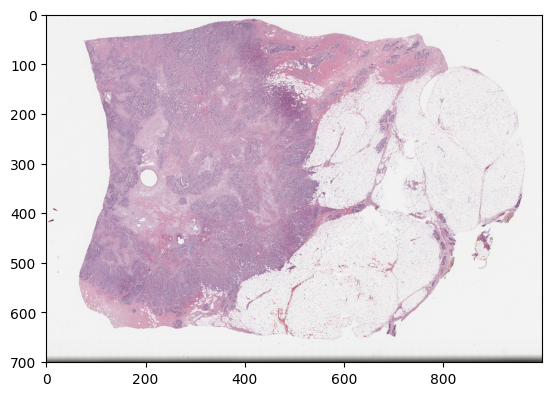

In [8]:
thum=wsi.get_thumbnail(size=(1000,1000))
plt.imshow(thum)

In [9]:
thum=thum.save('thum.png')

In [10]:
#################################################################################################################
###################################      generating MASK OF WSI        ##########################################
################################################################################################################# 

In [11]:
from histomicstk.saliency.tissue_detection import get_slide_thumbnail, get_tissue_mask
from PIL import Image
import os
deconvolve_first= True
n_thresholding_steps=1
mask_scale=4
patch_size=256
mask_save_dir= '/home1/ravi/ravi_data/mask_a6s9'
slide_id='TCGA-EW-A6S9'



mask_dim= (int(wsi_dim[0]*mask_scale/patch_size),int(wsi_dim[1]*mask_scale/patch_size))
wsi_thumbnail_rgb=wsi.get_thumbnail(mask_dim)    #returns PIL image
#convertion image object to numpy array
wsi_thumbnail_array= np.array(wsi_thumbnail_rgb)
labeled, mask= get_tissue_mask(wsi_thumbnail_array, deconvolve_first= deconvolve_first, n_thresholding_steps=n_thresholding_steps, sigma=0, min_size=30)
# converting labeled matrix to 0-1 matrix
label_bool=labeled
label_bool[labeled!=0]=1

# generating mask to image
wsi_thumbnail_array[label_bool==False]=0*wsi_thumbnail_array[label_bool==False]
#normalised mask if required wsi_mask_array= wsi_thumbnail_array/max(wsi_thumbnail_array)

wsi_mask_rgb= Image.fromarray(wsi_thumbnail_array)
#wsi_mask_rgb.show()
# save the mask
img_path= os.path.join(mask_save_dir, slide_id+'__img.png')
mask_path= os.path.join(mask_save_dir, slide_id+'__mask.png')
wsi_thumbnail_rgb.save(img_path)
wsi_mask_rgb.save(mask_path)


In [12]:
np.where(label_bool)[0]

array([  17,   17,   17, ..., 1285, 1285, 1285])

In [13]:
label_bool
import pandas as pd
df= pd.DataFrame(columns=['x','y'])
df['x'],df['y']=64*np.where(label_bool)[1],64*np.where(label_bool)[0]

In [14]:
df.shape

(419843, 2)

In [ ]:
###########################################################################################
################## GENERATING PATCHES using mask available for an image ###################
###########################################################################################

In [18]:
# we mul wsi by(4/256=1/64), that means one pixel on mask is 64x64 on wsi. hence patch on mask is 4x4
# and then we mul by 64 in coord then we will get 256x256 patch on wsi
patch_scale=64
patch_size_on_mask= int(mask_scale)
print(f'patch_size on mask : {patch_size_on_mask}')
patch_size_on_wsi= int(patch_scale*mask_scale)
print(f'size of patch on wsi: {patch_size_on_wsi}')
area_threshold=0.8

# max_patch = 500
# num_patches_store_png=50
patch_save_dir= '/home1/ravi/ravi_data/patches_a6s9_minecode'

#loop over mask to filter patches on the basis of area_threshold

start_x= np.min(np.nonzero(label_bool)[0])
start_y= np.min(np.nonzero(label_bool)[1])
stop_x= np.max(np.nonzero(label_bool)[0])
stop_y= np.max(np.nonzero(label_bool)[1])
step_size_xy= patch_size_on_mask
# ttrrt=patch_size_on_mask^2
# print(f' ttrrt is {ttrrt}')

patch_coord=[]

for y in range(start_y, stop_y, step_size_xy):
    for x in range(start_x, stop_x, step_size_xy):
        arr=label_bool[x:x+patch_size_on_mask, y:y+patch_size_on_mask]
        if np.sum(arr)> area_threshold*(patch_size_on_mask^2) and arr.std()< 32:
            wsi_patch_coord = (y*64,x*64)
#             wsi_patch_coord = (y*int(patch_size_on_wsi/patch_size_on_mask), x*int(patch_size_on_wsi/patch_size_on_mask))
#             print(wsi_patch_coord)
            patch_coord.append(wsi_patch_coord)

# print(f' ist element of patch_coord is : {patch_coord[2]}')
total_patches= len(patch_coord)
print(f'no of patches are :{total_patches}')

# saving the patches 
for i in range(total_patches):
#     print(i)
    sample= wsi.read_region(patch_coord[i], 0, (patch_size_on_wsi,patch_size_on_wsi))
    png_file_name = os.path.join(patch_save_dir, slide_id + '__'+ str(patch_coord[i][0])+ '_' + str(patch_coord[i][1]) + '.png')
    sample.save(png_file_name)
    
        

patch_size on mask : 4
size of patch on wsi: 256
no of patches are :34113


In [ ]:
################################################################################################################
###################### generate tiles without mask digitalsrini#################################################
################################################################################################################

In [30]:
from openslide.deepzoom import DeepZoomGenerator
patches= DeepZoomGenerator(wsi, tile_size=256, overlap=0, limit_bounds=False) 
#patches is obejct
print(f'the no of level in tiles object are: {patches.level_count}')
print(f'the dim of data in each level are: {patches.level_dimensions}')
print(f'total no of tiles are: {patches.tile_count}')

the no of level in tiles object are: 18
the dim of data in each level are: ((1, 1), (2, 2), (4, 3), (8, 6), (15, 11), (29, 21), (58, 41), (115, 81), (230, 161), (460, 322), (919, 644), (1837, 1287), (3673, 2574), (7346, 5148), (14691, 10296), (29382, 20591), (58764, 41181), (117527, 82362))
total no of tiles are: 197690


In [32]:
level_num =17 #want to see tiles at 17 dim as above
print(f'patches shape at level {level_num} is {patches.level_tiles[level_num]}')
print(f'this means there are {patches.level_tiles[level_num][0]*patches.level_tiles[level_num][1]}')

patches shape at level 17 is (460, 322)
this means there are 148120


In [33]:
patch_dim= patches.get_tile_dimensions(17, (1,1))
print(patch_dim)

(256, 256)


In [35]:
# visualising one patch
single_patch= patches.get_tile(17, (200,100))
single_patch_rgb=single_patch.convert('RGB')
single_patch_rgb.show()

In [ ]:
######################## save all the patches with white criterion 

In [29]:

import os
cols, rows = patches.level_tiles[17]

patch_dir= '/home1/ravi/ravi_data/patches_a6s9_200_32f/'
i=0
for row in range(rows):
        for col in range(cols):
            patch_name= os.path.join(patch_dir,'%d_%d' %(col, row))
#             print(f'Now saving patch with name as : {patch_name}')
            temp_patch=patches.get_tile(17, (col, row))
            temp_patch_rgb=temp_patch.convert('RGB')
            temp_patch_np= np.array(temp_patch_rgb)
#             plt.imsave(patch_name+'.png', temp_patch_np)
            
            if temp_patch_np.mean()< 200 and temp_patch_np.std()> 32:
                plt.imsave(patch_name+'.png', temp_patch_np)
                i+=1
print(f'no of patches after filter of 200 is :{i}')
                
            
                
        
        


NameError: name 'patches' is not defined

In [ ]:
# if we have img and mask of bigger size and want to cut into smaller size both the things then use patchify

In [ ]:
##################################################################################################################
################################### colornorm for existing patches ###############################################
##################################################################################################################

In [8]:
import glob
import cv2
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from histomicstk.preprocessing.color_normalization.deconvolution_based_normalization import deconvolution_based_normalization
cn_img_dir='/home1/ravi/ravi_data/patches_a6s9_200_32f_cn/'
W_target = np.array([[0.5807549,  0.08314027,  0.08213795],[0.71681094,  0.90081588,  0.41999816],[0.38588316,  0.42616716, -0.90380025]])
image_list= glob.glob('/home1/ravi/ravi_data/patches_a6s9_200_32f/*.png')

for i in range(len(image_list)):
    image_path= image_list[i]
    
    img = Image.open(image_path)
    img_rgb=img.convert('RGB')
    img_np=np.array(img_rgb)
    img_cn = deconvolution_based_normalization(img_np, W_target=W_target)
    patch_name=image_path.split('/')[-1].split('.')[0]
    name= os.path.join(cn_img_dir,patch_name)
    plt.imsave(name+'_cn.png',img_cn)
    
print(' color normalization is done')    


/home1/ravi/Desktop/jupyter/environment/lib/python3.8/site-packages/histomicstk/preprocessing/color_conversion/rgb_to_sda.py:48: RuntimeWarning: divide by zero encountered in log
  im_sda = -np.log(im_rgb/(1.*I_0)) * 255/np.log(I_0)


 color normalization is done
